# Getting Started with the Assistants API

During the public preview, the Assistants API is not available everywhere. Check https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview. I will use Sweden Central.

The API version to use in Azure is 2024-02-15-preview

Let's start creating an Azure OpenAI client...


In [1]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load environment variables from .env file
# AZURE_OPENAI_API_KEY
# AZURE_OPENAI_ENDPOINT
# AZURE_OPENAI_API_VERSION
load_dotenv()

# Create Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


## Creating the assistant

In [2]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="""You are a math tutor that helps users solve math problems. 
    You have access to a sandboxed environment for writing and testing code. 
    Explain to the user why you used the code and how it works
    """,
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-preview" # ensure you have a deployment in the region you are using
)

# display information about the assistant
print(assistant.model_dump_json(indent=2))


{
  "id": "asst_FxMeIXSW8Vj51ZuM2jojrr8x",
  "created_at": 1707409159,
  "description": null,
  "file_ids": [],
  "instructions": "You are a math tutor that helps users solve math problems. \n    You have access to a sandboxed environment for writing and testing code. \n    Explain to the user why you used the code and how it works\n    ",
  "metadata": {},
  "model": "gpt-4-preview",
  "name": "Math Tutor",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ]
}


Above, you can see an assistant has a unique ID. For some reason, you don't see this ID in the Azure OpenAI Playground. With OpenAI, the assistants you create are shown in their portal.

## Creating a thread

Now we can create a thread. A thread is **not linked** to the assistant at creation time

In [3]:
# Create a thread
thread = client.beta.threads.create()

# Threads have an id as well
print("Thread id: ", thread.id)

Thread id:  thread_Whz2Lr8cWOY2WlmVFRs972zs


## Adding a user question

Now we can add a user question to the thread via a **message**. The message is put on the thread via its ID.

After adding the message, we get the messages from the tread and dump them. Every message has an ID and content. The type of content we add is just text and comes from a user (role=user).

In [4]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
)

# Show the messages
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_OSlJDb9qcVNJqzKhZpb9N7HW",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
          },
          "type": "text"
        }
      ],
      "created_at": 1707409169,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_Whz2Lr8cWOY2WlmVFRs972zs"
    }
  ],
  "object": "list",
  "first_id": "msg_OSlJDb9qcVNJqzKhZpb9N7HW",
  "last_id": "msg_OSlJDb9qcVNJqzKhZpb9N7HW",
  "has_more": false
}


## Running a thread

Adding a message to a thread does not do much. To get a response from the assistant's model, we need to run the thread.

When you run the thread, you can provide extra instructions via the `instructions` parameter. We do not do that below.

A thread is run asychronously. We need to check the run status to see if it is done. After you run the cell below, keep running the cell under it until the status is `completed`. When it is not completed, the status is `in_progress`.

Other statuses: cancelled, expired, failed

In [5]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [29]:
# run this until the run is completed
# it can take a while before the run is completed
# in a real application, create a loop that waits for the run to complete
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

completed


## Result of the run

To see what happened, we have to check the messages of the thread. The user message will be at the bottom. There should be a message with role=assistant. This is the response from the assistant's model. The message has a `content` field with the response. There can be multiple types of responses, for instance text and image.

In [30]:
# dump the messages on the thread again
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_AD0iPlB0FO91676lbDGdQwKm",
      "assistant_id": "asst_FxMeIXSW8Vj51ZuM2jojrr8x",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-7YlYIGb2RFam2lZmiPktsMUr"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "To solve the given equation \\( y = x^2 + 3 \\) for \\( x = 3 \\) and plot the function graph, I applied the following steps:\n\n1. I created a function `f(x)` that represents the equation, so when we pass any value of `x`, it returns the corresponding value of `y`.\n2. I computed the value of `y` for `x = 3` by calling `f(3)`, which gives us 12. This represents a specific point on the graph where the `x` coordinate is 3.\n3. I created an array of `x` values ranging from -10 to 10, which serves as the domain for our graph. The function is then evaluated at each point to get the corresponding `y` values.\n4. Using Matplot

## Showing the response

We can show all messages in the array in reverse order to start from the beginning. Depending on the content (text, image) we can do something with it.

For now just print the text or file_id if there is one

In [31]:
import json

messages_json = json.loads(messages.model_dump_json())

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            print("Image ID:" , content['image_file']['file_id'], "\n")

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

To solve the given equation \( y = x^2 + 3 \) for \( x = 3 \) and plot the function graph, I applied the following steps:

1. I created a function `f(x)` that represents the equation, so when we pass any value of `x`, it returns the corresponding value of `y`.
2. I computed the value of `y` for `x = 3` by calling `f(3)`, which gives us 12. This represents a specific point on the graph where the `x` coordinate is 3.
3. I created an array of `x` values ranging from -10 to 10, which serves as the domain for our graph. The function is then evaluated at each point to get the corresponding `y` values.
4. Using Matplotlib, a Python plotting library, I plotted the graph of the function `y = x^2 + 3` across the generated range of `x` values.
5. I also plotted the specific point `(3, 12)` on the graph, which is highlighted in red to show where `x = 3` falls on the curve.
6. The plot includes labels, a legend, and a grid to i

## Retrieving the image file

Same code as above but show the image with PIL and IPython.display

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

To solve the given equation \( y = x^2 + 3 \) for \( x = 3 \) and plot the function graph, I applied the following steps:

1. I created a function `f(x)` that represents the equation, so when we pass any value of `x`, it returns the corresponding value of `y`.
2. I computed the value of `y` for `x = 3` by calling `f(3)`, which gives us 12. This represents a specific point on the graph where the `x` coordinate is 3.
3. I created an array of `x` values ranging from -10 to 10, which serves as the domain for our graph. The function is then evaluated at each point to get the corresponding `y` values.
4. Using Matplotlib, a Python plotting library, I plotted the graph of the function `y = x^2 + 3` across the generated range of `x` values.
5. I also plotted the specific point `(3, 12)` on the graph, which is highlighted in red to show where `x = 3` falls on the curve.
6. The plot includes labels, a legend, and a grid to i

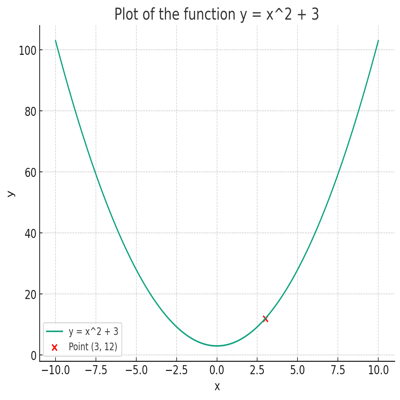

In [32]:
from PIL import Image
from IPython.display import display

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            file_id = content['image_file']['file_id']
            file_content = client.files.content(file_id)
            # use PIL with the file_content
            img = Image.open(file_content)
            img = img.resize((400, 400))
            display(img)
            
            


## Ask another question

We can add another user message to the thread and run it again. But now, we will wait for the response and display it right away.

We will use Markdown to display the assistant's response.

The new_run function is a helper function to add a question 

Status: completed


Solve the equation y = x^2 + 3 for x = 3 and plot the function graph.

To solve the given equation \( y = x^2 + 3 \) for \( x = 3 \) and plot the function graph, I applied the following steps:

1. I created a function `f(x)` that represents the equation, so when we pass any value of `x`, it returns the corresponding value of `y`.
2. I computed the value of `y` for `x = 3` by calling `f(3)`, which gives us 12. This represents a specific point on the graph where the `x` coordinate is 3.
3. I created an array of `x` values ranging from -10 to 10, which serves as the domain for our graph. The function is then evaluated at each point to get the corresponding `y` values.
4. Using Matplotlib, a Python plotting library, I plotted the graph of the function `y = x^2 + 3` across the generated range of `x` values.
5. I also plotted the specific point `(3, 12)` on the graph, which is highlighted in red to show where `x = 3` falls on the curve.
6. The plot includes labels, a legend, and a grid to improve readability.

As you can see in the plot, the parabola represents the function `y = x^2 + 3`, and the red dot shows the point where `x = 3`, confirming that `y = 12` when `x = 3`.

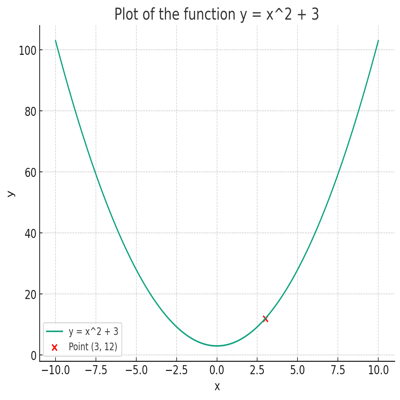

Is this a concave function?

The function \( y = x^2 + 3 \) is a quadratic function where the coefficient of the \( x^2 \) term is positive. In this case, the coefficient is 1, which is indeed positive. For quadratic functions of the form \( y = ax^2 + bx + c \), when \( a > 0 \), the parabola opens upwards, making the function a convex function rather than concave.

So, to answer your question, \( y = x^2 + 3 \) is not a concave function; it is a convex function. In the context of optimization, a convex function has a single minimum point and no maximum point, whereas a concave function would have a single maximum point and no minimum point. The plot shown previously demonstrates the convexity by the shape of the parabola opening upwards.

In [33]:
from IPython.display import clear_output, display, Markdown
import time

def new_run(question, thread_id):

    # add new message to the thread
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role="user",
        content=question
    )

    # run the tread again
    run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
    )

    status = run.status

    while status not in ["completed", "cancelled", "expired", "failed"]:
        time.sleep(2)
        run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
        status = run.status
        print(f'Status: {status}')
        clear_output(wait=True)

    print(f'Status: {status}')

    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )

    messages_json = json.loads(messages.model_dump_json())

    for item in reversed(messages_json['data']):
        # Check the content array
        for content in reversed(item['content']):
            # If there is text in the content array, print it as Markdown
            if 'text' in content:
                display(Markdown(content['text']['value']))
            # If there is an image_file in the content, print the file_id
            if 'image_file' in content:
                file_id = content['image_file']['file_id']
                file_content = client.files.content(file_id)
                # use PIL with the file_content
                img = Image.open(file_content)
                img = img.resize((400, 400))
                display(img)

new_run("Is this a concave function?", thread.id)

In [34]:
# create a new thread and run
thread = client.beta.threads.create()
new_run("If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age", thread.id)

Status: completed


If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age

To solve this problem, let's first define some variables and create an equation based on the information given:

- Let \( y \) be the number of years it takes for the age of the two children to be exactly half the mother's age.
- The mother's current age is 33 years.
- The age of the older child is 7 years.
- The age of the younger child is 5 years.

In \( y \) years, the mother will be \( 33 + y \) years old. We also know that in \( y \) years, the older child will be \( 7 + y \) years old, and the younger child will be \( 5 + y \) years old.

The sum of the ages of the two children in \( y \) years will be \( (7 + y) + (5 + y) \).

The condition we need to satisfy is that this sum is half of the mother's age in \( y \) years:

\[ (7 + y) + (5 + y) = \frac{1}{2} \times (33 + y) \]

Now, we will solve this equation to find \( y \).

The solution to the equation is \( y = 3 \). This means it will take 3 years for the combined ages of the two children to be exactly half the age of the mother.